# Задание 
## A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

**Вопросы**

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
  
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

**Требования к ответу**

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

#### Цель и задачи исследования

**Цель исследования** - проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей

**Задачи**

1. Загрузка и исследовательский анализ данных
3. Определение целевых метрик
4. Статистический анализ данных
5. Вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from tqdm.auto import tqdm

In [2]:
sns.set(
    font_scale=1.2,
    style="white",
    rc={'figure.figsize':(15,5)}
        )

### Загрузка и исследовательский анализ данных

**groups** - информация о принадлежности пользователя к контрольной или экспериментальной группе

In [3]:
groups = pd.read_csv('data/groups.csv', sep=';')

In [4]:
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [5]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
# дубликаты
groups.duplicated().sum()

0

In [7]:
# в датасете только уникальные id
groups.id.nunique() == groups.shape[0]

True

In [8]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [9]:
groups.grp.value_counts(normalize=True).round(3)

B    0.803
A    0.197
Name: grp, dtype: float64

В данных groups (деление пользователей на A контрольную группу и B целевую) 74484 строки, каждая строка - данные об уникальном пользователе и группе, в которую он входит. Эти пользователи разделены на группы с пропорции 20 на 80 (20% - контроль, 80% - целевая). Дубликатов и пропусков в данных нет.

---
**groups_add** - дополнительный файл с пользователями, получен позже

In [10]:
groups_add = pd.read_csv('data/group_add.csv')

In [11]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [12]:
# дубликаты
groups_add.duplicated().sum()

0

In [13]:
# в датасете только уникальные id
groups_add.id.nunique() == groups_add.shape[0]

True

In [14]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [15]:
groups_add.grp.value_counts(normalize=True).round(3)

B    0.761
A    0.239
Name: grp, dtype: float64

In [16]:
# проверка пересечения id с основным файлом
len(groups_add[groups_add.id.isin(groups.id.to_list())]) > 0

False

В данные groups_add по условиям задачи дополнительные данные о пользователях, который нам прислали спустя 2 дня после передачи данных (деление пользователей на A контрольную группу и B целевую). В приложенном фаайле 92 строки, каждая строка - данные об уникальном пользователе и группе, в которую он входит. Эти пользователи разделены на группы, пропорции схожи с основным файлом - примерно 20 на 80 (20% - контроль, 80% - целевая). Дубликатов и пропусков в данных нет.

Данные из дополнительного файла не пересекаются с данными основного по id, в нем новые id пользователей.

---
**checks** - файл с информацией об оплатах пользователей в дни проведения эксперимента

In [17]:
checks = pd.read_csv('data/checks.csv', sep=';')

In [18]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [19]:
# поменяем название колонки для унификации
checks.columns=['id', 'rev']

In [20]:
checks.head(3)

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [21]:
checks.rev.describe().to_frame()

,rev
count,541.000000
mean,1059.752317
std,762.712359
min,199.000000
25%,290.000000
50%,840.000000
75%,1900.000000
max,4650.000000


In [22]:
# дубликаты
checks.duplicated().sum()

0

In [23]:
# в датасете только уникальные id
checks.id.nunique() == checks.shape[0]

True

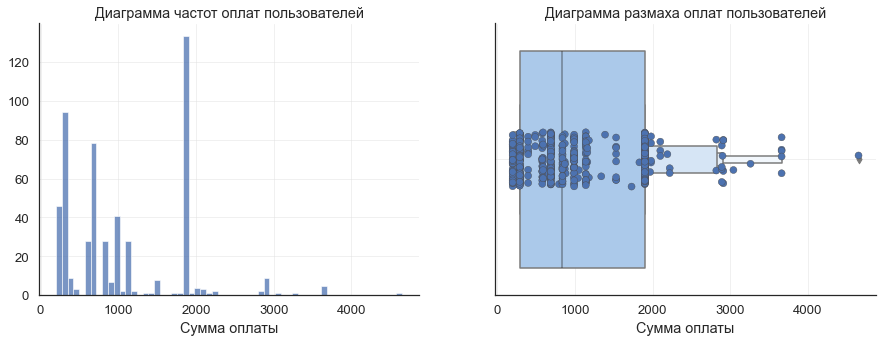

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=False)

sns.histplot(checks.rev, ax=ax[0], bins=60);
ax[0].set_title('Диаграмма частот оплат пользователей');
ax[0].set_xlabel('Сумма оплаты');
ax[0].set_ylabel('');
ax[0].grid(True, color='#e2e2e2', alpha=0.5)

sns.boxenplot(data = checks, x='rev', ax=ax[1],  palette='pastel');
sns.stripplot(data = checks, x='rev',
              size=7, palette='deep', linewidth=0.4, ax=ax[1])
ax[1].set_title('Диаграмма размаха оплат пользователей');
ax[1].set_xlabel('Сумма оплаты');

ax[1].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()

In [25]:
# топ-10 самых частых сумм оплаты
checks.rev.value_counts().head(10)

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
Name: rev, dtype: int64

In [26]:
# оплаты из основной группы эксперимента
checks[checks.id.isin(groups.id.to_list())].shape[0]

540

In [27]:
# оплаты из доп. группы эксперимента
checks[checks.id.isin(groups_add.id.to_list())].shape[0]

1

In [28]:
checks['is_paying'] = 1

В датасете с оплатами checks 541 строка (540 для основного списка, 1 для доп), id пользователей уникальны - то есть либо оплата на сайте не предполагает повторных покупок, либо это данные не по транзакциям, а по суммарной выручке на пользователя за период эксперимента. Данные по оплатам распределены ненормально, есть несколько пиков (самый выделяющийся на 1900) и  крупные платежи, тянущие среднее вправо (медианный платеж 840, средний - 1060). Дубликатов и пропусков нет.

---
**active_studs** - файл с информацией о пользователях, которые зашли на сайт в дни проведения эксперимента

In [29]:
active_studs = pd.read_csv('data/active_studs.csv')

In [30]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [31]:
# поменяем название колонки для унификации
active_studs.columns = ['id']

In [32]:
# в датасете только уникальные id
active_studs.id.nunique() == active_studs.shape[0]

True

In [33]:
# число активных пользователей из основной группы эксперимента
active_studs[active_studs.id.isin(groups.id.to_list())].shape[0]

8328

In [34]:
# число активных пользователей из доп. группы эксперимента
active_studs[active_studs.id.isin(groups_add.id.to_list())].shape[0]

13

In [35]:
# активные студенты, которые производили оплату
active_studs[active_studs.id.isin(checks.id.to_list())].shape[0]

392

In [36]:
# студенты, не заходившие на сайт, но оплачивавшие в это время
checks[~checks.id.isin(active_studs.id.to_list())].shape[0]

149

In [37]:
# студенты, не заходившие на сайт, но оплачивавшие в это время есть в обоих группах
checks[~checks.id.isin(active_studs.id.to_list())].merge(groups, how='inner', on='id')\
                .groupby('grp', as_index=False)[['id']].count()

,grp,id
0,A,29
1,B,120


In [38]:
checks[~checks.id.isin(active_studs.id.to_list())].merge(groups, how='inner', on='id')\
                .grp.value_counts(normalize=True)

B    0.805369
A    0.194631
Name: grp, dtype: float64

In [39]:
active_studs['is_active'] = 1

Датасет active_studs содержит данные об активных студентах(пользователях, которые зашли на платформу в дни проведения эксперимента). Мы проверили, что все из этого списка входят в общий + доп список, никаких лишних id в нем нет, то есть все id из датасета  включены в эксперимент. 

Однако активных студентов среди плативших всего 392. То есть существует 149 id студентов, входящих в экспериментальные группы, оплативших что-то в дни проведения эксперимента, но при этом не посещавших сайт. Интересно, что они принадлежат как группе А, так и группе В (в тех же пропорциях).

Это странно. Навскидку предположим:

- Сломалась система логирования посещения сайта. Что делать: сообщить о баге и искать дыру - может, пользователи заходили из какого-то определенного браузера, или, не знаю, с включенным VPN))(вероятная версия. Но огда получается, у нас недостоверны данные о количестве активных пользователей: если некоторое количество пользователей из экспериментальной группы совершили покупку и при этом не попали в список активных, наверняка существует некоторое количество не совершивших покупку и не попавших в список активных, какое - неизвестно.)
- В список оплат каким-то образом попали транзакции прошлых периодов(менее вероятно, т.к. данные пользователи входят в группы эксперимента, причем часть из них - в группу В, тестирующую новую механику оплаты. Сомнительно, что можно воспользоваться ей, не заходя на сайт, тем более в прошлых периодах).
- Это подписочные платежи: пользователь оформил подписку когда-то давно, а в период проведения эксперимента списался очередной платеж. (тоже вероятная версия, плюс она дает нам надежду, что данные достоверны)
  
Примем третье предположение, как наиболее оптимистичное)), и удалим платежи неактивных пользователей.


In [40]:
checks_cor = checks[checks.id.isin(active_studs.id.to_list())].copy()

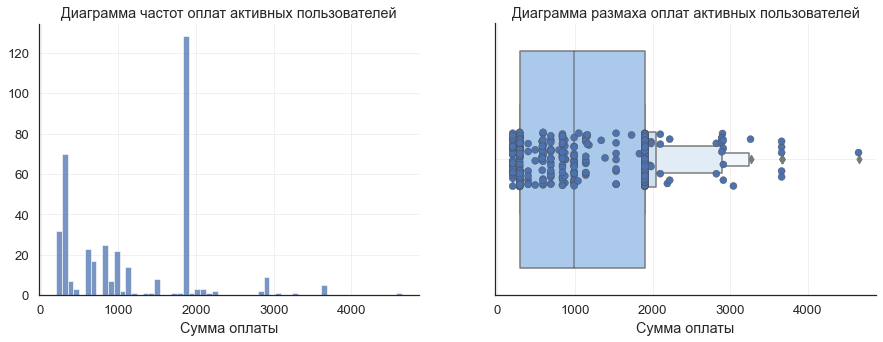

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=False)

sns.histplot(checks_cor.rev, ax=ax[0], bins=60);
ax[0].set_title('Диаграмма частот оплат активных пользователей');
ax[0].set_xlabel('Сумма оплаты');
ax[0].set_ylabel('');
ax[0].grid(True, color='#e2e2e2', alpha=0.5)

sns.boxenplot(data = checks_cor, x='rev', ax=ax[1],  palette='pastel');
sns.stripplot(data = checks_cor, x='rev',
              size=7, palette='deep', linewidth=0.4, ax=ax[1])
ax[1].set_title('Диаграмма размаха оплат активных пользователей');
ax[1].set_xlabel('Сумма оплаты');

ax[1].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()

In [42]:
# топ-10 самых частых сумм оплаты активных пользователей
checks_cor.rev.value_counts().head(10)

1900.0000    93
290.0000     70
1900.0001    35
199.0000     32
840.0000     24
990.0000     22
690.0000     17
590.0000     11
1140.0000    11
580.0000     11
Name: rev, dtype: int64

После удаления подписочных платежей данные об оплатах сохраняют уже виденные нами тенденции.

#### Вывод по загрузке и разведывательному анализу данных

В данных `groups` (деление пользователей на A контрольную группу и B целевую) каждая строка - данные об уникальном пользователе и группе, в которую он входит. Пользователи разделены на группы в пропорции 20 на 80 (20% - контроль, 80% - целевая).
  
Данные из дополнительного файла `groups_add`, присланного нам позже, не пересекаются с данными основного, в нем новые id пользователей, деленных на группы в той же пропорции.
  
В датасете с оплатами `checks` id плативших пользователей также уникальны - то есть либо оплата на сайте не предполагает повторных покупок, либо это данные по суммарной выручке на пользователя за период эксперимента. Данные по суммам платежей распределены ненормально, есть несколько пиков (самый выделяющийся на 1900) и выбросы, тянущие среднее вправо.

Датасет `active_studs` содержит данные об активных пользователях, которые зашли на платформу во время эксперимента. Все id из данного датасета входят в `groups`.

Однако мы выяснили, что среди плативших пользователей, есть 149 id, входящих в экспериментальные группы, оплативших что-то в дни проведения эксперимента, но при этом не посещавших сайт (не включенных в `active_studs`). Эти id принадлежат как группе А, так и группе В (в тех же пропорциях).

Мы предположили самый оптимистичный сценарий - это подписочные платежи: пользователь оформил подписку когда-то давно, а в период проведения эксперимента списался очередной платеж и удалили платежи неактивных пользователей, чтобы избежать зашумления данных.

---

### Метрики 

>*Дисклеймер*: для того, чтобы сделать верные выводы об итогах эксперимента, для начала нужно знать, насколько корректно задизайнен эксперимент: 
>* Насколько качественно проведено разделение групп на контроль и тест? Да и вообще довольно странно, что контроль 20%, а тест 80%, может быть, они перепутаны? 
>* Совпадают ли эти 2 группы по полу/возрасту/географии? 
>* Репрезентативна ли выборка? 
>* Был ли проведен А/А тест?
>* Попадают ли в выборку только новые пользователи?   
>   Поясню последний вопрос:то есть не влияет ли на результаты теста предыдущий пользовательский опыт? Для этого желательно, чтобы участие в эксперименте приняли только пользователи, никогда не пользовавшиеся механизмом оплаты на сайте - если не новые, но не покупавшие ничего ранее.



>Также, для того, чтобы корректно интерпретировать результаты, нужно до начала эксперимента понимать, на какие бизнес-задачи должно оказать влияние изменение, цель эксперимента (желательно, по SMART) и какие будут целевые метрики (а также стоит отслеживать какие-то опережающие метрики, например, скорость прохождения всех этапов оплаты, либо Guardrail метрики, например, количество ошибок при оплате, или отток в процессе оплаты, а также, конечно, следить, чтобы не произошло ухудшение других важных для бизнеса метрик).

>Все это нам точно не известно, так что тут мы ступаем на скользкий лед предположений)) 
___

**Гипотеза, которую мы хотим проверить:** новая механика оплаты услуг на сайте увеличивает показатели выручки. 

**Возможные целевые метрики:** 
* C1 - конверсия пользователя в покупку (число покупок/число активных пользователей), 
* AOV - средний чек пользователя(сумма заказов/число транзакций), 
* ARPU (кумулятивная средняя выручка с пользователя 
* ARPAU (средняя выручка с активного пользователя), точнее ARPU, 
* ARPPU (средняя выручка с платящего пользователя)точнее ARPAU), 
* Repeat Purchase Rate (доля повторных покупок). 

**Особенности данных:** У нас нет данных о транзакциях, а также есть данные только об уникальных id (либо повторные покупки невозможны, либо в данных кумулятивный доход с одного пользователя за время эксперимента), так что AOV и Repeat Purchase Rate отпадают. 

**Вывод:**

Таким образом, мы могли бы сравнить C1, ARPU, ARPAU, ARPPU.
Однако, так как данные о платежах измеряются сотнями, тогда как о пользователях - десятками тысяч, эта ARPU не будет достаточно чувствительной, и если значимые изменения есть - их не покажет. Принимать решение надо было по результатам сравнения ARPPU и С1 (и, возможно, ARPAU).


**Дополнительное решение:** Но ведь это учебный проект! Так что мы посчитаем все метрики (C1, ARPU, ARPAU, ARPPU), и посмотрим, что получится)))

---
Сначала посмотрим на различия в метриках

In [43]:
df = groups\
            .merge(checks_cor, how='left', on='id')\
            .merge(active_studs, how='left', on='id')\
            .fillna(0)

In [44]:
df.head()

,id,grp,rev,is_paying,is_active
0,1489,B,0.0,0.0,0.0
1,1627,A,990.0,1.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


In [45]:
df_metrics = df.groupby('grp').agg({'id':'count',
                                    'is_active': 'sum',
                                    'is_paying': 'sum',
                       'rev':['sum',
                               lambda x: round(x.sum()/len(x), 3),
                              lambda x: round(x.sum()/sum(x>0), 3)]
                        })

In [46]:
df_metrics.columns = ['total_users',  'active_users', 'paying_users', 'payment_sum','ARPU', 'ARPPU']

In [47]:
df_metrics['ARPAU'] = (df_metrics.payment_sum / df_metrics.active_users).round(3)

In [48]:
df_metrics['C1'] = (df_metrics.paying_users / df_metrics.active_users).round(4)

In [49]:
df_metrics

,total_users,active_users,paying_users,payment_sum,ARPU,ARPPU,ARPAU,C1
grp,,,,,,,,
A,14671,1535.0,78.0,72820.0000,4.964,933.590,47.440,0.0508
B,59813,6793.0,313.0,393074.0035,6.572,1255.827,57.865,0.0461


Мы сгруппировали данные (контроль/тест) и посмотрели на метрики. Мы видим, что данные по выручке отличаются в тестовой и контрольокй группе, но конверсия в покупку даже упала.

Проверим на следующем этапе анализа, является ли изменение метрик статистически значимым.

### Статистический анализ

Для сравнения контрольных и тестовых групп используем тест Т-стьюдента для независимых выборок, так как ARPU, ARPAU, ARPPU это средние, да и конверсию можно представить в виде среднего нулей и единиц (т.е. все эти метрики - выборочные средние). Выборки разного размера, так что предположим, что дисперсии ген.совокупностей не равны, учтем это в параметрах ттеста. 

Учитывая, что в ARPPU выборка довольно мала (а метрика самая перспективная), проверим также средние дополнительно бутстрапом. А конверсию классическим тестои хи-квадрат.

Так как при сравнении разных метрик число наблюдений будет различаться, для каждой метрики установим свой пороговый уровень вероятности соверщить ошибку 1 рода (alpha).

#### Подготовка данных
Разделим дф на контроль и тест.

In [50]:
control_df = groups[groups.grp == 'A']\
                    .merge(checks_cor, how='left', on='id')\
                    .merge(active_studs, how='left', on='id').fillna(0)

In [51]:
test_df = groups[groups.grp == 'B']\
                    .merge(checks_cor, how='left', on='id')\
                    .merge(active_studs, how='left', on='id').fillna(0)

#### Сравнение ARPU 

**Нулевая гипотеза:** ARPU в тестовой и контрольной группе равен друг другу.


**Альтернативная гипотеза:** ARPU в тестовой группе больше, чем в контрольной (односторонняя).

**Alpha** 0.01 (т.к. мы проводим тест на выборке в сотни тысяч наблюдений)

In [52]:
control_df_users = control_df[['id', 'rev']]

In [53]:
test_df_users = test_df[['id', 'rev']]

In [54]:
alpha = 0.01

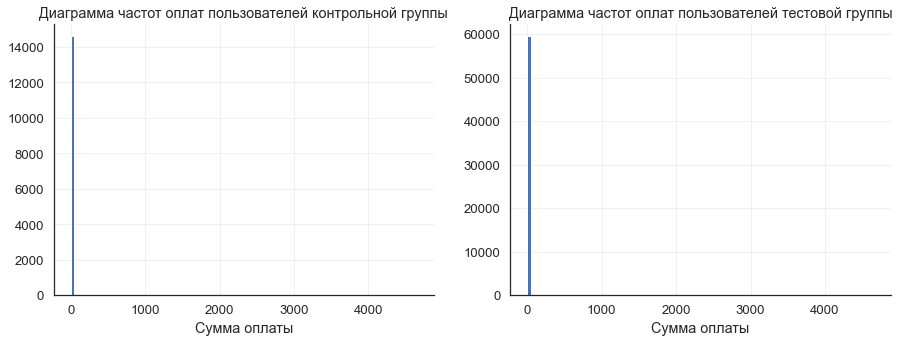

In [55]:
#посмотрим на распределение признака
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=False)
control_df_users.rev.hist(bins=100, ax=ax[0]);
ax[0].set_title('Диаграмма частот оплат пользователей контрольной группы');
ax[0].set_xlabel('Сумма оплаты');
ax[0].set_ylabel('');
ax[0].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
test_df_users.rev.hist(bins=100, ax=ax[1]);
ax[1].set_title('Диаграмма частот оплат пользователей тестовой группы');
ax[1].set_xlabel('Сумма оплаты');
ax[1].set_ylabel('');
ax[1].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()

График неинформативен, так как большая часть пользователей не являются покупателями (сумма покупки равна нулю).

In [56]:
# ттест для независимых выборок, нераные дисперсии
stat, pvalue = st.ttest_ind(test_df_users.rev,
                            control_df_users.rev,
                            equal_var = False,
                            alternative = 'greater')

In [57]:
# тест односторонний вправо:
# отвергаем гипотезу только тогда, когда среднее теста значимо больше среднего контроля
print(f'{pvalue=}')
if (pvalue < alpha) and (test_df_users.rev.mean() > control_df_users.rev.mean()):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу") 

pvalue=0.03688146188932143
Не получилось отклонить нулевую гипотезу


Вероятность получить такие же, или более сильные различия при условии, что нулевая гипотеза верна выше выбранного уровня значимости (с учетом односторонности альтернативной гипотезы), так что у нет оснований отвергнуть нулевую гипотезу о равенстве ARPU в тестовой и контрольной группе.

___
По результатам теста мы не отклоняем нулевую гипотезу о равенстве ARPU в тестовой и контрольной группе. 

#### Сравнение ARPAU 

**Нулевая гипотеза:** ARPAU в тестовой и контрольно группе равен друг другу.


**Альтернативная гипотеза:** ARPAU в тестовой группе больше, чем в контрольной.


**Alpha** 0.01 (т.к. мы проводим тест на выборке в тысячи наблюдений)

In [58]:
control_df_active_users = control_df[control_df.is_active>0]

In [59]:
test_df_active_users = test_df[test_df.is_active>0]

In [60]:
alpha = 0.01

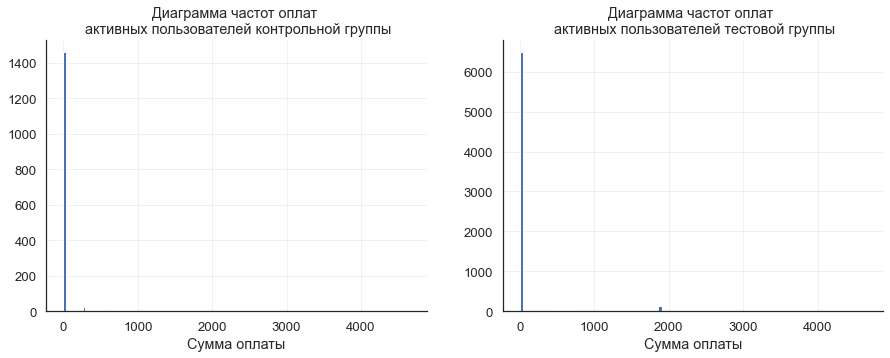

In [61]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=False)
control_df_active_users.rev.hist(bins=100, ax=ax[0]);
ax[0].set_title('Диаграмма частот оплат \n активных пользователей контрольной группы');
ax[0].set_xlabel('Сумма оплаты');
ax[0].set_ylabel('');
ax[0].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
test_df_active_users.rev.hist(bins=100, ax=ax[1]);
ax[1].set_title('Диаграмма частот оплат \n активных пользователей тестовой группы');
ax[1].set_xlabel('Сумма оплаты');
ax[1].set_ylabel('');
ax[1].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()

График неинформативен, как и предыдущий, хотя данных об активных пользователях значительно меньше, их большая часть не являются покупателями (сумма покупки равна нулю).

In [62]:
stat, pvalue = st.ttest_ind(test_df_active_users.rev,
                            control_df_active_users.rev, 
                            equal_var = False, 
                           alternative = 'greater')

In [63]:
# тест односторонний вправо:
# отвергаем гипотезу только тогда, когда  среднее теста значимо больше среднего контроля
print(f'{pvalue=}')
if (pvalue < alpha) and (test_df_active_users.rev.mean() 
                             > control_df_active_users.rev.mean()):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу") 

pvalue=0.10565379542653419
Не получилось отклонить нулевую гипотезу


Вероятность получить такие же, или более сильные различия при условии, что нулевая гипотеза верна выше выбранного уровня значимости, так что у нас нет оснований отвергнуть нулевую гипотезу о равенстве ARPAU в тестовой и контрольной группе

___
По результатам теста мы не отклоняем нулевую гипотезу о равенстве ARPAU в тестовой и контрольной группе. 

#### Сравнение ARPPU 

**Нулевая гипотеза:** ARPPU в тестовой и контрольно группе равен друг другу.

**Альтернативная гипотеза:** ARPPU в тестовой группе больше, чем в контрольной.

**Альфа** 0.05 (т.к. размер выборки измеряется сотнями, тест менее мощный)

In [64]:
control_df_paying_users = control_df[control_df.rev > 0]

In [65]:
test_df_paying_users = test_df[test_df.rev > 0]

In [66]:
alpha = 0.05

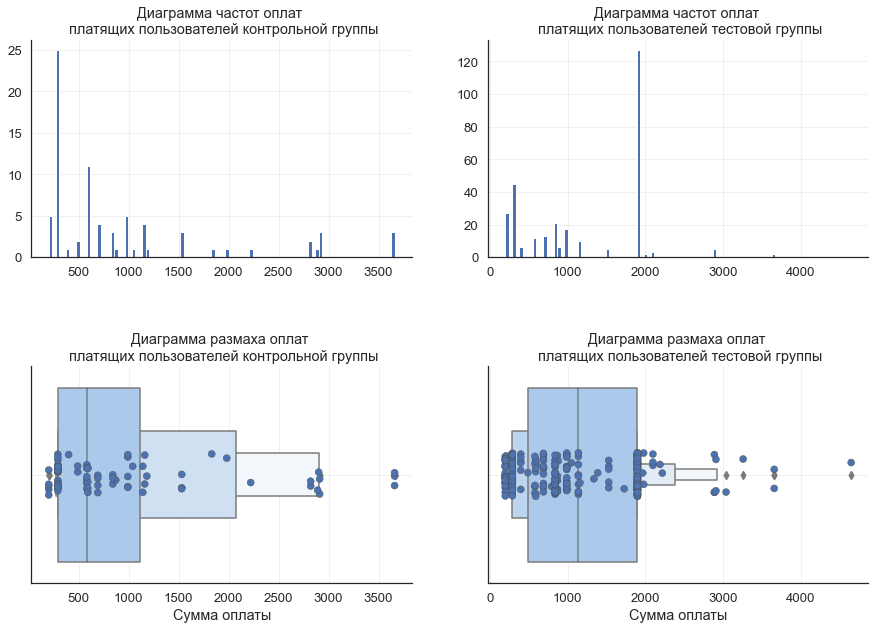

In [67]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex=False, sharey=False)
ax = ax.flatten()
control_df_paying_users.rev.hist(bins=100, ax=ax[0]);
ax[0].set_title('Диаграмма частот оплат \n платящих пользователей контрольной группы');
ax[0].set_xlabel('');
ax[0].set_ylabel('');
ax[0].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
plt.subplots_adjust(hspace=0.5)

test_df_paying_users.rev.hist(bins=100, ax=ax[1]);
ax[1].set_title('Диаграмма частот оплат \n платящих пользователей тестовой группы');
ax[1].set_xlabel('');
ax[1].set_ylabel('');
ax[1].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
plt.subplots_adjust(hspace=0.5)

sns.boxenplot(data=control_df_paying_users, x='rev', ax=ax[2],  palette='pastel');
sns.stripplot(data=control_df_paying_users, x='rev',
              size=7, palette='deep', linewidth=0.4, ax=ax[2])
ax[2].set_title('Диаграмма размаха оплат \n платящих пользователей контрольной группы');
ax[2].set_xlabel('Сумма оплаты');
ax[2].set_ylabel('');
ax[2].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
plt.subplots_adjust(hspace=0.5)

sns.boxenplot(data=test_df_paying_users, x='rev', ax=ax[3],  palette='pastel');
sns.stripplot(data=test_df_paying_users, x='rev',
              size=7, palette='deep', linewidth=0.4, ax=ax[3])
ax[3].set_title('Диаграмма размаха оплат \n платящих пользователей тестовой группы');
ax[3].set_xlabel('Сумма оплаты');
ax[3].set_ylabel('');
ax[3].grid(True, color='#e2e2e2', alpha=0.5)
sns.despine()
plt.subplots_adjust(hspace=0.5)

Эти графики уже интереснее: на них мы видим, что особенностью распределения платежей в тестовой группе является пик на значении около 1900, который предсказуемо тянет все статистики вправо. 

Таких платежей очень много, на реальных данных у нас обязательно возникли бы вопросы, откуда они взялись. Не связано ли это с какой-то акцией, проходившей в это время (это плохо, так как на эксперимент не должны влиять никакие изменения, кроме целевых), либо изменение механики оплаты было направлено на увеличение именно таких платежей (например, стимулирование покупки какого-то продукта на этапе оплаты), и тогда это хорошо, своей цели мы достигли.

In [68]:
stat, pvalue = st.ttest_ind(test_df_paying_users.rev,
                            control_df_paying_users.rev, 
                            equal_var = False, 
                           alternative = 'greater')

In [69]:
#тест односторонний вправо:
#отвергаем гипотезу только тогда, когда когда среднее теста значимо больше среднего контроля
print(f'{pvalue=}')
if (pvalue < alpha) and (test_df_paying_users.rev.mean()
                         > control_df_paying_users.rev.mean()):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу") 

pvalue=0.002679291204696783
Отклоняем нулевую гипотезу


Вероятность получить такие же, или более сильные различия при условии, что нулевая гипотеза верна ниже выбранного уровня значимости (и даже если бы мы поставили более строгий критерий, результат был бы тем же), так что у нас есть основания отвергнуть нулевую гипотезу о равенстве ARPPU в тестовой и контрольной группе

Так как размер выборки с платящими пользователями довольно мал, попробуем подтвердить или опровергнуть наши результаты с помощью бутстрапа.

In [70]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

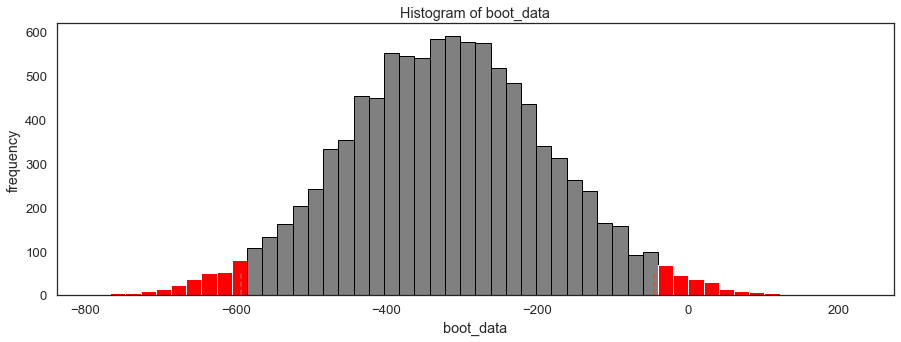

In [71]:
booted_df = get_bootstrap(control_df_paying_users.rev, 
                            test_df_paying_users.rev)

In [72]:
booted_df["p_value"]

0.02021799868036522

In [73]:
booted_df["quants"] 

,0
0.025,-593.436546
0.975,-44.778532


Мы видим, что сравнение средних с помощью бутстрапа дают нам результат приблизительно такой же, как и при т-тесте. Ноль не входит в доверительный интервал и вероятность получить такие (или еще более экстремальные) различия между выборками при условии верной нулевой гипотезы - менее 5%, значит у нас есть основания ее отклонить

---
У нас есть достаточно оснований отклонить нулевую гипотезу о равенстве ARPPU в тестовой и контрольной группе, и принять альтернативную, изменения в ARPPU статистически значимы

---
#### Сравнение C1

Мы видим, что конверсия в покупку у нас несколько уменьшилась, это опасный признак - уменьшение конверсии может перечеркнуть все результаты увеличения ARPPU. Проверим, насколько значимы эти изменения. Конверсию можно представить сумму нулей и единиц в колонке is_paying, деленное на число активных пользователей (т.е. среднее выборки), так что для сравнения средних можем использовать тот же критерий Стьюдента.

А также проведем тест хи-квадрат для категориальных переменных.

**Нулевая гипотеза:** С1 в тестовой и контрольно группе равны друг другу.

**Альтернативная гипотеза:** С1 в тестовой группе меньше, чем в контрольной.

**Альфа** 0.01 

In [74]:
alpha = 0.01

In [75]:
control_df_active_users.head(3)

,id,grp,rev,is_paying,is_active
0,1627,A,990.0,1.0,1.0
11,3391,A,0.0,0.0,1.0
71,109623,A,0.0,0.0,1.0


In [76]:
stat, pvalue = st.ttest_ind(test_df_active_users.is_paying, 
                            control_df_active_users.is_paying,
                            equal_var=False,
                           alternative='greater')

In [77]:
#тест односторонний влево:
#отвергаем гипотезу только тогда, когда среднее теста значимо меньше среднего контроля
print(f'{pvalue=}')
if (pvalue < alpha) and (test_df_active_users.is_paying.mean()
                             < control_df_active_users.is_paying.mean()):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу") 

pvalue=0.7791303123182116
Не получилось отклонить нулевую гипотезу


Вероятность получить такие же, или более сильные различия при условии, что нулевая гипотеза верна значительно выше выбранного уровня значимости, так что у нас нет оснований отвергнуть нулевую гипотезу о равенстве С1 в тестовой и контрольной группе. 



In [78]:
df_cross = pd.crosstab(df[df.is_active > 0].grp, df[df.is_active > 0].is_paying)
df_cross

is_paying,0.0,1.0
grp,,
A,1457,78
B,6480,313


In [79]:
chi2_value, p_value, df_value, expected_array = st.chi2_contingency(df_cross)

In [80]:
print(f'Хи-квадрат = {chi2_value:.3f}, p-value = {p_value:.3f}')

Хи-квадрат = 0.527, p-value = 0.468


 P-value > 0.05. Следовательно, взаимосвязи между группой и покупками - нет

---
Конверсия из активных пользователей в платящих равна в тестовой и контрольной группах, ее уменьшение статистически не значимы. 

#### Вывод по статистическому анализу

Для определения, являются ли различия в метриках статистически значимыми, мы применили критерий Т-Стьюдента для  сравнения средних двух независимых выборок и получили следующие результаты:
- Изменения в ARPU статистически не значимы
- Изменения в ARPAU статистически не значимы
- Изменения в ARPPU статистически **значимы**
- Изменения в C1 статистически не значимы

Таким образом, мы уверились, что изменений в конверсии активного опльзователя в покупку при изменении механики оплаты не произошло. 

Как мы и предполагали, так как данные о платежах измеряются сотнями, тогда как о пользователях - десятками тысяч, эта метрики ARPU и даже ARPAU недостаточно чувствительны.

Изменения в ARPPU статистически значимы, в тестовой группе с новой механикой оплаты средняя выручка на платящего пользователя выше, чем в контрольной.

Также мы выснили, что особенностью распределения платежей в тестовой группе является пик на значении около 1900, который предсказуемо тянет все статистики вправо.

Таких платежей очень много, на реальных данных у нас обязательно возникли бы вопросы, откуда они взялись. Не связано ли это с какой-то акцией, проходившей в это время (это плохо, так как на эксперимент не должны влиять никакие изменения, кроме целевых), либо изменение механики оплаты было направлено на увеличение именно таких платежей (например, стимулирование покупки какого-то продукта на этапе оплаты), и тогда это хорошо, своей цели мы достигли.

### Общий вывод


Мы проанализировали итоги эксперимента. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Проводя предварительный анализ данных, мы выяснили, что часть пользователей, совершивших оплату, не входит в группу активных пользователей (т.е посещавших сайт во время эксперимента). Мы предположили, что это подписочные платежи и исключили их их данных. 

**Гипотеза, которую мы хотим проверить:** новая механика оплаты услуг на сайте увеличивает показатели выручки.

**Возможные целевые метрики с учетом особенностей данных:**
- C1 - конверсия пользователя в покупку (число покупок/число активных пользователей),
- ARPU (кумулятивная средняя выручка с пользователя
- ARPAU (средняя выручка с активного пользователя),
- ARPPU (средняя выручка с платящего пользователя)

Если учесть разный размер выборок для этих метрик из-за низкой конверсии, самой перспективной выглядит ARPPU. Но мы проверили, есть ли статистические различия в каждой из выбранных метрик. 

По результатам исследования мы выяснили, что метрика ARPPU в тестовой группе действительно статистически значимо выросла, в остальных метриках статистически значимых изменений не выявлено (ARPU и ARPAU незначительно уменьшились, С1 несначительно упала). 

Еще один инсайт - мы обнаружили пик (сумма около 1900) в тестовой группе, происхождение которого нам неизвестно. Он может как скомпроментировать наш эксперимент (если это влияние каких-то еще маркетинговых активностей или акций), так и подтвердить его успех (если так сработало изменение механики оплаты). 

Запускать ли изменения механики оплаты на всех пользователей? Если происхождение этого пика одинаковых платежей не было бы посторонним, моя рекомендация - запускать новую механику на всех пользователей (учитывая дисклеймер из пункта о метриках).

---


## SQL


### Очень усердные ученики.

**Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Oчень усердный ученик == пользователь, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Данные**

default.peas:

- st_id	(int) -	ID ученика
- timest	(timestamp)	- Время решения карточки
- correct	(bool)	- Правильно ли решена горошина?
- subject	(text)	-Дисциплина, в которой находится горошина

**Задание**
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.


In [81]:
import pandahouse as ph

In [82]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password': 'dpo_python_2020'
                     }

In [83]:
#функция-обертка подключения
def select(sql):
    return ph.read_clickhouse(sql, connection=connection_default)

In [84]:
sql = '''
SELECT
    min(CAST(timest, 'Date')) AS min_timest, 
    max(CAST(timest, 'Date')) AS max_timest
FROM default.peas

'''

In [85]:
select(sql)

,min_timest,max_timest
0,2021-10-30,2021-10-31


Данные в базе только за 2 дня, так что, естественно, за текущий месяц результат будет 0. Но запрос вот такой

In [86]:
#количество очень усердных студентов (за текущий месяц)
sql = '''

SELECT COUNT(st_id)    
FROM    
    (
    SELECT 
        st_id,
        toStartOfMonth(timest) as month, 
        sum(correct) as corr_answers
        
    FROM default.peas 
    WHERE month == toStartOfMonth(now())
    GROUP BY st_id, month
    HAVING corr_answers >=20
    )

'''

In [87]:
select(sql)

,count(st_id)
0,0


In [88]:
#проверим сколько усердных учеников в данных вообще
sql = '''

SELECT COUNT(st_id)    
FROM    
    (
    SELECT 
        st_id,
        toStartOfMonth(timest) as month, 
        sum(correct) as corr_answers
        
    FROM default.peas 
    GROUP BY st_id, month
    HAVING corr_answers >=20
    )

'''

In [89]:
select(sql)

,count(st_id)
0,136


### Запрос с метриками

**Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

**Данные:**
default.peas (см. выше), 

default.studs:

- st_id	(int) 	- ID ученика
- test_grp	(text) -	Метка ученика в данном эксперименте


default.final_project_check:

- st_id	(int) - ID ученика
- sale_time	(timestamp)	- Время покупки
- money	(int)	- Цена, по которой приобрели данный курс
- subject	(text) 	- Дисциплина, на которую приобрели полный доступ

**Задача**

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.


In [90]:
sql = '''
select count(st_id) as ids, uniqExact( st_id) as id_unic, ids == id_unic as is_equal
from studs
'''

In [91]:
select(sql)

,ids,id_unic,is_equal
0,600,600,1


Оказыватеся, в studs только уникальные id, в запросе это уточнять не нужно

In [92]:
#искомый запрос 
sql = '''
select test_grp,
    round(sum(money_sum) / count(st_id), 2) as ARPU,
    round(sumIf(money_sum, corr_tasks > 10) / sum(is_active), 2) as ARPAU,
    round(sum(is_buy) / count(st_id), 4) as CR,
    round(sum(is_act_buy) / sum(is_active), 4) as CR_act,
    round(sum(is_math_buy) / sum(is_active_math), 4) as CR_act_math
    
from
    (select st.st_id as st_id,
        test_grp,
        corr_tasks,
        money_sum,
        if(corr_tasks > 10 , 1, 0) as is_active,
        if(money_sum > 0, 1, 0) as is_buy,
        if(corr_tasks > 10 and money_sum > 0, 1, 0) as is_act_buy,
        if(corr_tasks_math >= 2, 1, 0) as is_active_math,
        if(corr_tasks_math >= 2 and money_sum_math > 0, 1, 0) as is_math_buy
        
    from studs st
    left join 
        (select st_id, 
                sum(correct) as corr_tasks,
                sumIf(correct, subject=='Math') as corr_tasks_math
            from peas 
            group by st_id
        ) p on p.st_id = st.st_id
    left join 
        (select st_id, 
            sum(money) as money_sum,
            sumIf(money, subject == 'Math') as money_sum_math
        from 
            final_project_check
         group by  st_id
        ) c on st.st_id = c.st_id
    
    group by st_id,
                test_grp, 
                corr_tasks, 
                money_sum, 
                money_sum_math, 
                corr_tasks_math)
group by test_grp

    
    '''

In [93]:
select(sql)

,test_grp,ARPU,ARPAU,CR,CR_act,CR_act_math
0,control,4540.98,10393.70,0.0492,0.1102,0.0612
1,pilot,11508.47,29739.58,0.1085,0.2604,0.0952


In [94]:
#искомый запрос с визуализацией
sql = '''
select test_grp,
    round(sum(money_sum) / count(st_id), 2) as ARPU,
    bar(ARPU, 0, 13000, 5) AS ARPU_bar,
    round(sumIf(money_sum, corr_tasks > 10) / sum(is_active), 2) as ARPAU,
    bar(ARPAU, 0, 30000, 5) AS ARPAU_bar,
    round(sum(is_buy) / count(st_id), 4) as CR,
    bar(CR, 0, 0.13, 5) AS CR_bar,
    round(sum(is_act_buy) / sum(is_active), 4) as CR_act,
    bar(CR_act, 0, 0.3, 5) AS CR_act_bar,
    round(sum(is_math_buy) / sum(is_active_math), 4) as CR_act_math,
    bar(CR_act_math, 0, 0.1, 5) AS CR_act_math_bar
    
from
 
    (select st.st_id as st_id,
        test_grp,
        corr_tasks,
        money_sum,
        if(corr_tasks > 10 , 1, 0) as is_active,
        if(money_sum > 0, 1, 0) as is_buy,
        if(corr_tasks > 10 and money_sum > 0, 1, 0) as is_act_buy,
        if(corr_tasks_math >= 2, 1, 0) as is_active_math,
        if(corr_tasks_math >= 2 and money_sum_math > 0, 1, 0) as is_math_buy
        
    from studs st
    left join 
        (select st_id, 
                sum(correct) as corr_tasks,
                sumIf(correct, subject=='Math') as corr_tasks_math
            FROM peas 
            GROUP BY st_id
        ) p on p.st_id = st.st_id
    left join 
        (select st_id, 
            sum(money) as money_sum,
            sumIf(money, subject == 'Math') as money_sum_math
        from 
            final_project_check
         group by  st_id
        ) c on st.st_id = c.st_id
    
    group by st.st_id,
        test_grp, corr_tasks, money_sum, money_sum_math, corr_tasks_math)
group by test_grp

    
    '''

In [95]:
#в табиксе выглядит симпатичнее
select(sql)

,test_grp,ARPU,ARPU_bar,ARPAU,ARPAU_bar,CR,CR_bar,CR_act,CR_act_bar,CR_act_math,CR_act_math_bar
0,control,4540.98,█▋,10393.70,█▋,0.0492,█▊,0.1102,█▋,0.0612,███
1,pilot,11508.47,████▍,29739.58,████▊,0.1085,████▏,0.2604,████▎,0.0952,████▋


## Python. Функции

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Добавление новых данных и построение таблицы с метриками
При реализации функции мы считаем, что у нас уже есть таблицы в следующем виде:

In [96]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [97]:
checks.head()

,id,rev,is_paying
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [98]:
active_studs.head()

,id,is_active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


Предполагаю, что будет удобнее, если мы сделаем 2 функции - 
1. добавляющую id эксперимента в базу 
2. показывающую таблицу с метриками.   
(и 3. строящую график)

Нет никаких сложностей собрать их в одну, но мне кажется, логично написать две: тогда мы сможем более гибко обновлять файлы и сравнивать метрики разных пользователей. Предполагается, что алгоритм будет таким: есть базовые данные -> строим табличку и график -> пришла добавка -> добавили к основной таблице -> строим табличку и график на обновленных данных -> пришла добавка -> добавили к основной таблице -> и т.д.

Также в условии задачи не сказано, что таблица с чеками и таблица активных юзеров обновляются, предполагаем, что нет.

In [99]:
def add_group_to_base_df(path, base_group=groups):
    """Добавляем дополнительные данные в таблицу принадлежности к группам эксперимента.

    Файл должен содержать только уникальные id.
    """
    added_group = pd.read_csv(path,  names=['id', 'grp'], header=0)
    if len(added_group) == added_group.id.nunique(): #проверка на уникальные id
        #добавляем только id, которых нет в исходном файле
        new_groups = pd.concat([base_group, 
                                added_group[~added_group.id
                                            .isin(base_group.id.to_list())]])
        if len(new_groups) > len(base_group):
            return new_groups
        else:
            print('UpdateError! There\'s no new users in new data')
        
    else:
        print('DataError! Ids are not unique')

In [100]:
def show_metric_table(groups):
    """Выводит таблицу с ARPU, ARPPU, ARPAU, C1"""
    #собираем все данные
    df = groups\
            .merge(checks_cor, how='left', on='id')\
            .merge(active_studs, how='left', on='id')\
            .fillna(0)
    #строим результиующую таблицу
    df_metrics = df.groupby('grp').agg({'id':'count',
                                    'is_active': 'sum',
                                    'is_paying': 'sum',
                       'rev':['sum',
                               lambda x: round(x.sum()/len(x), 3),
                              lambda x: round(x.sum()/sum(x>0), 3)]
                        })
    df_metrics.columns = ['total_users',  
                              'active_users', 
                              'paying_users', 
                              'payment_sum',
                              'ARPU', 
                              'ARPPU']
    df_metrics['ARPAU'] = (df_metrics.payment_sum / df_metrics.active_users).round(3)
    df_metrics['C1'] = (df_metrics.paying_users / df_metrics.active_users).round(4)
        
        
    return df_metrics.reset_index()

In [101]:
#check
path = 'group_add.csv'

In [102]:
#добавляем данные к исходному датасету
new_group = add_group_to_base_df(path, groups)

In [103]:
#строим таблицу метрик по исходному датасету
show_metric_table(groups)

,grp,total_users,active_users,paying_users,payment_sum,ARPU,ARPPU,ARPAU,C1
0,A,14671,1535.0,78.0,72820.0000,4.964,933.590,47.440,0.0508
1,B,59813,6793.0,313.0,393074.0035,6.572,1255.827,57.865,0.0461


In [104]:
#строим таблицу метрик по датасету с обновленными данными
show_metric_table(new_group)

,grp,total_users,active_users,paying_users,payment_sum,ARPU,ARPPU,ARPAU,C1
0,A,14693,1538.0,78.0,72820.0000,4.956,933.590,47.347,0.0507
1,B,59883,6803.0,314.0,394974.0035,6.596,1257.879,58.059,0.0462


In [105]:
#т.к. функция добавляет только новые id,  второй вызов с тем же файлом вернет ошибку
add_group_to_base_df(path, new_group)

UpdateError! There's no new users in new data


### Строим графики по метрикам

In [111]:
def show_metrics_chart(df):
    """Строит барчарт сравнения ARPU, ARPPU, ARPAU, C1, тест и контроль"""
    metrics = ['ARPU', 'ARPPU', 'ARPAU', 'C1']
    fig, axes = plt.subplots(2,2, figsize=(15,10))
    axes = axes.flatten()
    for metric, ax in zip(metrics, axes):
        sns.barplot(data = df,  y=metric, x='grp', ax=ax, palette='vlag')
        ax.grid(True, color='#e2e2e2', alpha=0.5)
        ax.set_title(f'Сравнение метрики {metric}\n')
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticks(range(len(df)))
        ax.set_xticklabels(['Control', 'Test'])
        plt.subplots_adjust(hspace=0.5)
        sns.despine()
    
    return fig,

In [112]:
new_metrics = show_metric_table(new_group)

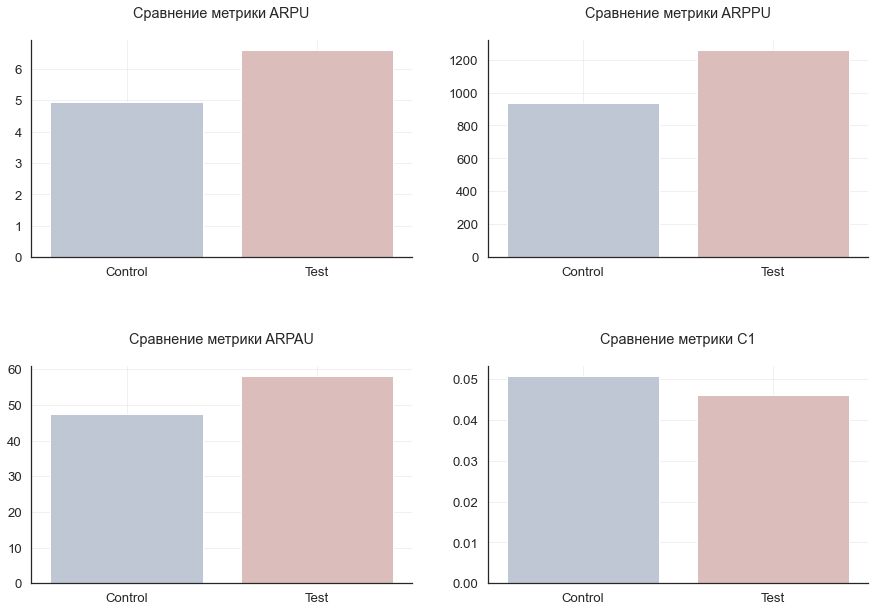

In [113]:
show_metrics_chart(new_metrics);